# Dose-response

## Load packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

## Specify filepaths

In [2]:
source_plate = 'data/20220315_plate.xlsx'
plate_data = 'data/20220317_5fc_dose-response.xlsx'
graph_outpath = 'graphs/'

In [3]:
plate_df = pd.read_excel(source_plate, header=0)
plate_df.head(6)

,well,compound,concentration,strain,genotype,replicate
0,B2,5-FC,200.000000,LL13-040,WT,1
1,B3,5-FC,3.125000,LL13-040,WT,1
2,B4,5-FC,1.562500,LL13-040,WT,1
3,B5,5-FC,0.781250,LL13-040,WT,1
4,B6,5-FC,0.390625,LL13-040,WT,1
5,B7,5-FC,0.195312,LL13-040,WT,1


## Get plate reader data

In [4]:
def get_data(fpath):
    source_df = pd.read_excel(fpath, header=1, index_col=0,skiprows=[2],
                              #skipfooter=34
                             )
    source_df.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)
    longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
    longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD') # wide to long dataframe
    return longdf

In [5]:
df = get_data(plate_data)
df.head(6)

,well,time (h),OD
0,B2,0.0,0.092850
1,B3,0.0,0.094875
2,B4,0.0,0.094400
3,B5,0.0,0.094700
4,B6,0.0,0.095500
5,B7,0.0,0.093675


In [6]:
merged = df.merge(right=plate_df, on=['well'])
merged.head(6)

,well,time (h),OD,compound,concentration,strain,genotype,replicate
0,B2,0.0,0.092850,5-FC,200.0,LL13-040,WT,1
1,B2,0.25,0.097100,5-FC,200.0,LL13-040,WT,1
2,B2,0.5,0.098250,5-FC,200.0,LL13-040,WT,1
3,B2,0.75,0.098475,5-FC,200.0,LL13-040,WT,1
4,B2,1.0,0.098500,5-FC,200.0,LL13-040,WT,1
5,B2,1.250278,0.098800,5-FC,200.0,LL13-040,WT,1


## Calculate growth rate

In [7]:
def get_growth_rate(g):
    # rate is multiplied by 4 to convert from /15min (measurements every 15 min) to /h
    data_diff = g.OD.diff()*4
    get_top_5 = data_diff.nlargest(5)    
    growth_rate = np.median(get_top_5)
    return growth_rate

In [8]:
gr = merged.groupby(['strain','concentration','well'])[['OD']].apply(func=get_growth_rate).reset_index(name='growth_rate')
gr.head(6)

,strain,concentration,well,growth_rate
0,LL13-040,0.000000,B11,0.12652
1,LL13-040,0.000000,C11,0.12828
2,LL13-040,0.000000,D11,0.12284
3,LL13-040,0.024414,B10,0.11808
4,LL13-040,0.024414,C10,0.11820
5,LL13-040,0.024414,D10,0.11620


In [9]:
max_vals = {}
for s in gr.strain.unique():
    max_vals[s] = gr.loc[gr.strain == s, 'growth_rate'].max()
max_vals

{'LL13-040': 0.12827999999999973, 'NC-02': 0.13240000000000007}

In [10]:
gr['ic'] = gr.apply(lambda row: (max_vals[row.strain] - row.growth_rate) / max_vals[row.strain], axis=1)
gr.drop(gr[gr.concentration==0].index, inplace=True)
gr['norm_gr'] = 1-gr['ic']
gr.head(3)

,strain,concentration,well,growth_rate,ic,norm_gr
3,LL13-040,0.024414,B10,0.11808,0.079514,0.920486
4,LL13-040,0.024414,C10,0.11820,0.078578,0.921422
5,LL13-040,0.024414,D10,0.11620,0.094169,0.905831


In [23]:
# Average inhibition coefficient at 1.5625 ug/mL 5-FC for each strain
gr[gr.concentration==1.5625].groupby(['strain','concentration']).agg({'ic': ['mean', 'std']})

ic          
                            mean       std
strain   concentration                    
LL13-040 1.5625         0.935142  0.008173
NC-02    1.5625         0.918026  0.003328

## Get Hill equation fit

In [11]:
def hill_equation(x, E, n):
    # this function defines the hill equation, where:
    # x is the drug concentration
    # E is the concentration with half effect (IC50)
    # n is the hill coefficient,    
    return 1/(1+((E/x)**n))

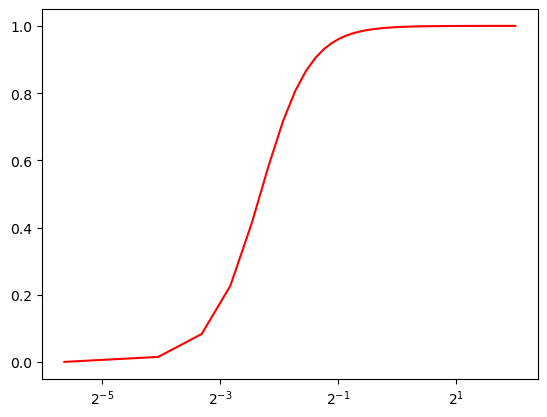

In [145]:
x = np.linspace(0.02, 4, 100)
plt.plot(x, hill_equation(x, 0.2, 3.48), color='red')
plt.xscale('log', base=2)

In [12]:
import scipy as sci

def get_fit(eq, xy_data, x_col, y_col, spec_col, spec_val):
    # Retrieve x and y values
    x_val = xy_data.loc[xy_data[spec_col] == spec_val, x_col].values
    y_val = xy_data.loc[xy_data[spec_col] == spec_val, y_col].values
    # Get best fit parameters (popt) and covariance matrix (pcov)
    popt, pcov = sci.optimize.curve_fit(eq, x_val, y_val, p0=[0.05,2.6])
    return popt

In [13]:
coeffs = {}
for s in gr.strain.unique():
    coeffs[s] = get_fit(hill_equation, xy_data=gr.groupby(['strain','concentration'])[['ic']].mean().reset_index(),
                           x_col='concentration', y_col='ic',
                           spec_col='strain', spec_val=s)
print(coeffs)

{'LL13-040': array([0.26501792, 1.18522884]), 'NC-02': array([0.23133895, 1.27893839])}


In [14]:
fit_vals = np.logspace(np.log2(gr.concentration.min()),np.log2(gr.concentration.max()), num=50, base=2)

## Growth curves

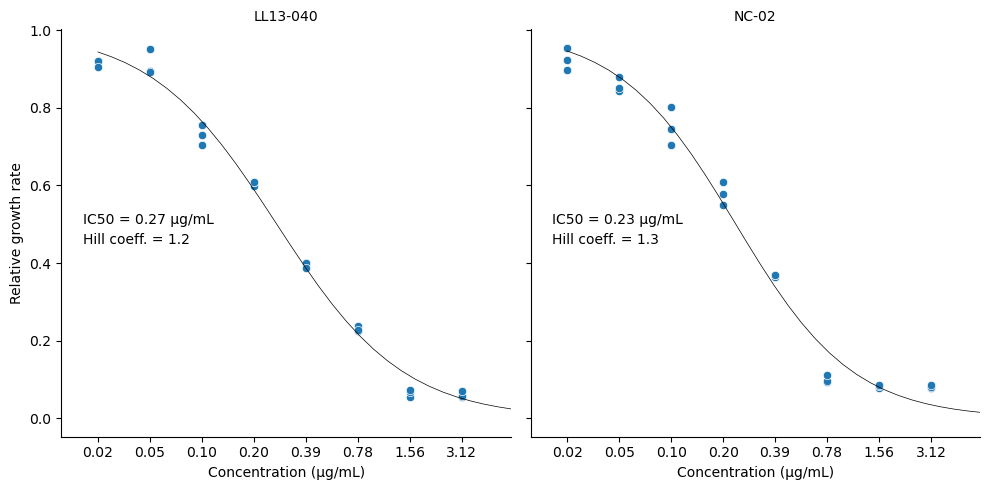

In [34]:
from matplotlib.ticker import FormatStrFormatter

fig = sns.relplot(data=gr, x='concentration', y='norm_gr', col='strain', height=5)
plt.xscale('log',base=2)
fig.set(xticks=gr.concentration.unique(),
        xlim=(0.015,6))
fig.axes[0][0].set_xticklabels(gr.concentration.unique())
fig.axes[0][0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

for i, v in enumerate(gr.strain.unique()):
    fig.axes[0][i].plot(fit_vals, [1 - hill_equation(x, coeffs[v][0], coeffs[v][1]) for x in fit_vals], 'k-', linewidth=0.5)
    fig.axes[0][i].annotate('IC50 = {:.2f} μg/mL'.format(coeffs[v][0]),(.02,.5))
    fig.axes[0][i].annotate('Hill coeff. = {:.1f}'.format(coeffs[v][1]),(.02,.45))
    
fig.set_titles(col_template='{col_name}')
fig.set_axis_labels('Concentration (μg/mL)', 'Relative growth rate')
fig.tight_layout()
plt.savefig(graph_outpath+'20230331_dose-response.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230331_dose-response.png', format='png', dpi=300)